In [1]:
import os
import sys
import glob

path = os.path.dirname(os.getcwd())
new_path = os.path.join(path, 'src')
sys.path.insert(0,new_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
import scipy as sp
import math
import scipy.signal as signal
import data.raw_data_processing as proc


## Process all files in folder
cut out the signal between entry and exit peaks, and remove background

In [6]:
path = os.path.dirname(os.getcwd())
print(path)
all_files = glob.glob(os.path.join(path, 'data','Tube_Data','Raw','*.csv'))
filt_path = os.path.join(path, 'data','Tube_Data','Filtered_AG')
counter=0
#filter first 
print('found' ,len(all_files), 'files' )
for file in all_files:
    if (counter%100 == 0):
        print('file no:', counter)
    counter=counter+1
    name=os.path.basename(file)
    der_name=(name.split('.'))[0]+'_der.csv'
    A0=pd.read_csv(file,header=[5])
    A0n=proc.clip_signal(A0)
    A0m=proc.subtract_background(A0n)
    A0_der=proc.get_derivatives(A0m)
    A0m.to_csv(os.path.join(filt_path,name),index=False)
    A0_der.to_csv(os.path.join(filt_path,der_name),index=False)
    

C:\Users\gmueller\Documents\GitHub\epri_Mar20
found 3 files
file no: 0


## detect the peaks. 
1st: summ all channels, 
2nd run low pass filter
3rd fit a trendline through the peaks 
4th eliminate all that are offset below the trendline
5th keep evenly spaced peaks

### testing and illustration 

In [7]:
A01=pd.read_csv(os.path.join(path, 'data','Tube_Data','Raw', 'AP04_601_000_raw.csv'),header=[5])

#run these functions on some test files:
A01n=proc.clip_signal(A01)
A01m=proc.subtract_background(A01n)
A01_der=proc.get_derivatives(A01m)

In [8]:
#loading the pre-processed trajectories from files
A04m=pd.read_csv(os.path.join(path, 'data','Tube_Data', 'Filtered_AG','AP04_601_000_raw.csv'))
A01m=pd.read_csv(os.path.join(path, 'data','Tube_Data','Filtered_AG','AP01_609_000_raw.csv'))

In [9]:
summed_channels=proc.sum_up_channels(A01m)
my_high_peaks, my_width = proc.extract_peak_locations(A01m,'AP01_601_000_raw.csv')

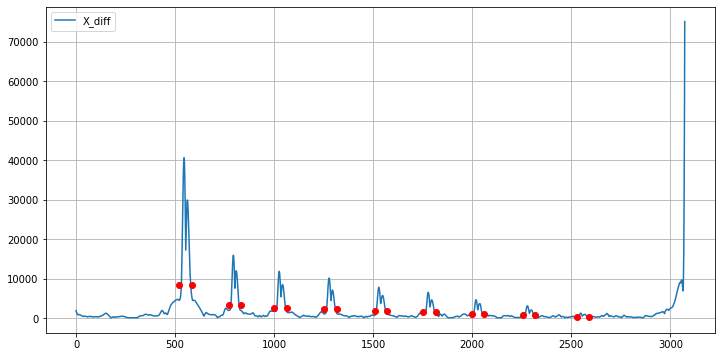

In [10]:
#A Figure to illustrate the peak selection 
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))

ax.plot(summed_channels['Sum_Abs'],label='X_diff')

ax.plot(my_width[2],my_width[1],'ro')
ax.plot(my_width[3],my_width[1],'ro')

ax.legend()
ax.legend()
ax.grid(True)


<function matplotlib.pyplot.show(*args, **kw)>

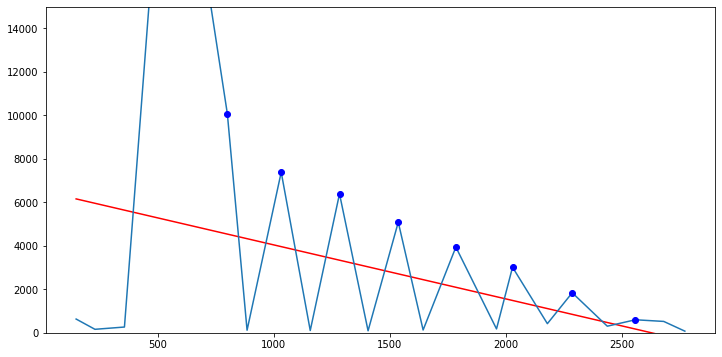

In [11]:
#Illustration of how butterworth filter is used to obtain only highest peaks
b, a = signal.butter(2, 0.03)
sig_ff = signal.filtfilt(b, a, summed_channels.Sum_Abs) 

#and detect signals
peaks, prop=signal.find_peaks((sig_ff), width=[20,200], distance=50)

#collect peak properties in a dataframe
my_peaks=pd.DataFrame(prop)
my_peaks.insert(0,'ind',peaks)

gradient, intercept, r_value, p_value, std_err = stats.linregress(my_peaks.ind,my_peaks.prominences)

intercept=intercept-500
mn=np.min(my_peaks.ind)
mx=np.max(my_peaks.ind)
x1=np.linspace(mn,mx,my_peaks.ind.shape[0])
y1=gradient*x1+intercept

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_ylim(0,15000)
ax.plot(x1,y1,'-r')

ax.plot(my_peaks.ind,my_peaks.prominences, label='prom')
ax.plot(my_high_peaks.ind,my_high_peaks.prominences, 'bo', label='high prom')
plt.show

##  Load all processed signals and get peaks
 find flaw boundaries and cut out from main and derivatives files

In [12]:
FLAWS = ['I','H',  'G','F',  'E','D', 'C','B', 'A' ]

In [13]:
#now process all files in folder
#this outputs some files with problems that were not clipped correctly 
#these are re-processed below
path = os.path.dirname(os.getcwd())
main_files = glob.glob(os.path.join(path, 'data','Tube_Data','Filtered_AG','*raw.csv'))
der_files = glob.glob(os.path.join(path, 'data','Tube_Data','Filtered_AG','*der.csv'))
filt_path = os.path.join(path, 'data','filtered_AG')
der_path = os.path.join(path, 'data','filtered_AG_derivatives')

counter=0
#filter first 
for file in main_files:
    der_file=der_files[counter]
    if (counter%100 == 0):
        print('file no:', counter)
    counter=counter+1
    name=os.path.basename(file)
    name=name.strip('raw.csv') 
    name_parts = name.split('_')
    
    data=pd.read_csv(file)
    der_data=pd.read_csv(der_file)
    
    # find peak locations based on summing channels and filtering steps
    try:
        my_high_peaks, my_width = proc.extract_peak_locations(data, name)
        run = 1
    except:
        print('problems with file:{}'.format(name))
        run=0
        
    if (run==1):    
        frames=proc.clip_signal_to_peaks(data, my_width)
        der_frames = proc.clip_signal_to_peaks(der_data, my_width)
        #write output files 
        i=0
        for f in frames:
            name=name_parts[0]+'_'+name_parts[1]+'_'+FLAWS[i]+'_'+name_parts[2]+'_fAG.csv'
            f.to_csv(os.path.join(filt_path,name),index=False)
            i=i+1
        i=0
        for f in der_frames:
            name=name_parts[0]+'_'+name_parts[1]+'_'+FLAWS[i]+'_'+name_parts[2]+'_der.csv'
            f.to_csv(os.path.join(der_path,name),index=False)
            i=i+1

file no: 0


## Now deal with the files that were problematic

In [14]:
raw_path = os.path.join(path, 'data','Tube_Data','Raw')

In [ ]:
A02_290=pd.read_csv(os.path.join(raw_path,'AP02_613_290_raw.csv'),header=[5])
C01_350=pd.read_csv(os.path.join(raw_path,'CP01_607_350_raw.csv'),header=[5])
R04_30=pd.read_csv(os.path.join(raw_path,'RP04_604_030_raw.csv'),header=[5])
R04_40=pd.read_csv(os.path.join(raw_path,'RP04_604_040_raw.csv'),header=[5])
R04_50=pd.read_csv(os.path.join(raw_path,'RP04_604_050_raw.csv'),header=[5])
R04_60=pd.read_csv(os.path.join(raw_path,'RP04_604_060_raw.csv'),header=[5])
R04_110=pd.read_csv(os.path.join(raw_path,'RP04_604_110_raw.csv'),header=[5])
R04_140=pd.read_csv(os.path.join(raw_path,'RP04_604_140_raw.csv'),header=[5])
R06_30=pd.read_csv(os.path.join(raw_path,'RP06_621_030_raw.csv'),header=[5])
W04_80=pd.read_csv(os.path.join(raw_path,'WT04_578_080_raw.csv'),header=[5])
W04_120=pd.read_csv(os.path.join(raw_path,'WT04_578_120_raw.csv'),header=[5])
W05_30=pd.read_csv(os.path.join(raw_path,'WT05_606_030_raw.csv'),header=[5])
W05_50=pd.read_csv(os.path.join(raw_path,'WT05_606_050_raw.csv'),header=[5])


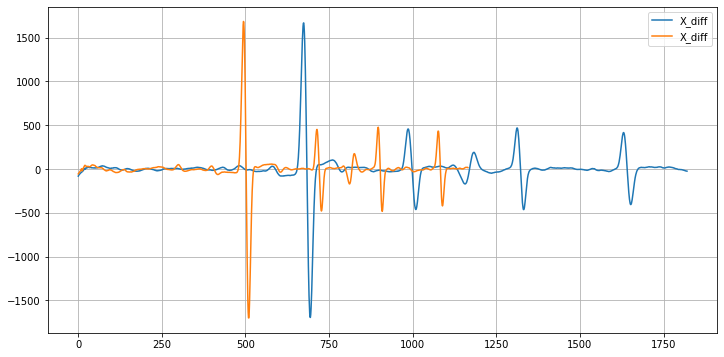

In [4]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))

ax.plot(W05_30['X11'],label='X_diff')
ax.plot(W05_50['X11'],label='X_diff')

#ax.plot(my_width[2],my_width[1],'ro')
#ax.plot(my_width[3],my_width[1],'ro')

ax.legend()
ax.legend()
ax.grid(True)

For the problematic signals, the tube entry or exit points were not properly detected. Repeat the pocedure for these based on a different frequency

In [ ]:
A02_290=pd.read_csv(os.path.join(filt_path,'AP02_613_290_raw.csv'),header=[5])
C01_350=pd.read_csv(os.path.join(filt_path,'CP01_607_350_raw.csv'),header=[5])
R04_30=pd.read_csv(os.path.join(filt_path,'RP04_604_030_raw.csv'),header=[5])
R04_40=pd.read_csv(os.path.join(filt_path,'RP04_604_040_raw.csv'),header=[5])
R04_50=pd.read_csv(os.path.join(filt_path,'RP04_604_050_raw.csv'),header=[5])
R04_60=pd.read_csv(os.path.join(filt_path,'RP04_604_060_raw.csv'),header=[5])
R04_110=pd.read_csv(os.path.join(filt_path,'RP04_604_110_raw.csv'),header=[5])
R04_140=pd.read_csv(os.path.join(filt_path,'RP04_604_140_raw.csv'),header=[5])
R06_30=pd.read_csv(os.path.join(filt_path,'RP06_621_030_raw.csv'),header=[5])
W04_80=pd.read_csv(os.path.join(filt_path,'WT04_578_080_raw.csv'),header=[5])
W04_120=pd.read_csv(os.path.join(filt_path,'WT04_578_120_raw.csv'),header=[5])
W05_30=pd.read_csv(os.path.join(filt_path,'WT05_606_030_raw.csv'),header=[5])
W05_50=pd.read_csv(os.path.join(filt_path,'WT05_606_050_raw.csv'),header=[5])


In [26]:
channels = ['X01','Y01','X02','Y02','X03','Y03','X04','Y04','X05','Y05',
           'X06','Y06','X07','Y07','X08','Y08','X09','Y09','X10','Y10',
           'X11','Y11','X12','Y12','X13','Y13','X14','Y14','X15','Y15',
           'X16','Y16','X17','Y17','X18','Y18','X19','Y19','X20','Y20']


In [27]:
#clilp based on one channel only and check
A02_290=proc.clip_signal(A02_290,['X12'])
C01_350=proc.clip_signal(W05_50,['X11'])
R04_30=proc.clip_signal(W05_50,['X11'])
R04_40=proc.clip_signal(W05_50,['X11'])
R04_50=proc.clip_signal(R04_50,['X11'])
R04_60=proc.clip_signal(R04_60,['X11'])
R04_110=proc.clip_signal(R04_110,['X11'])
R04_140=proc.clip_signal(R04_140,['X11'])
R06_30=proc.clip_signal(R06_30,['X11'])
W04_80=proc.clip_signal(W04_80,['X11'])
W04_120=proc.clip_signal(W04_120,['X11'])
W05_30=proc.clip_signal(W05_30,['X11'])
W05_50=proc.clip_signal(W05_50,['X11'])


In [6]:
A02_290=pd.read_csv('Tube_Data\\Filtered_AG\\AP02_613_290_raw.csv')
C01_350=pd.read_csv('Tube_Data\\Filtered_AG\\CP01_607_350_raw.csv')
R04_30=pd.read_csv('Tube_Data\\Filtered_AG\\RP04_604_030_raw.csv')
R04_40=pd.read_csv('Tube_Data\\Filtered_AG\\RP04_604_040_raw.csv')
R04_50=pd.read_csv('Tube_Data\\Filtered_AG\\RP04_604_050_raw.csv')
R04_60=pd.read_csv('Tube_Data\\Filtered_AG\\RP04_604_060_raw.csv')
R04_110=pd.read_csv('Tube_Data\\Filtered_AG\\RP04_604_110_raw.csv')
R04_140=pd.read_csv('Tube_Data\\Filtered_AG\\RP04_604_140_raw.csv')
R06_30=pd.read_csv('Tube_Data\\Filtered_AG\\RP06_621_030_raw.csv')
W04_80=pd.read_csv('Tube_Data\\Filtered_AG\\WT04_578_080_raw.csv')
W04_120=pd.read_csv('Tube_Data\\Filtered_AG\\WT04_578_120_raw.csv')
W05_30=pd.read_csv('Tube_Data\\Filtered_AG\\WT05_606_030_raw.csv')
W05_50=pd.read_csv('Tube_Data\\Filtered_AG\\WT05_606_050_raw.csv')


In [28]:
#subtract background and save
path = os.path.dirname(os.getcwd())
filt_path = os.path.join(path, 'data','Tube_Data','Filtered_AG')

names=['AP02_613_290_raw.csv','CP01_607_350_raw.csv','RP04_604_030_raw.csv','RP04_604_040_raw.csv',
       'RP04_604_050_raw.csv','RP04_604_060_raw.csv','RP04_604_110_raw.csv','RP04_604_140_raw.csv',
            'RP06_621_030_raw.csv','WT04_587_080_raw.csv','WT04_587_120_raw.csv',
       'WT05_606_030_raw.csv','WT05_606_050_raw.csv' ]
i=0 
for A0n in [A02_290,C01_350,R04_30,R04_40,R04_50,R04_60,R04_110,R04_140,
            R06_30,W04_80,W04_120,W05_30,W05_50 ]:

    A0m=proc.subtract_background(A0n) 
    A0_der=proc.get_derivatives(A0m)
    name=names[i]
    der_name=(name.split('.'))[0]+'_der.csv'

    A0m.to_csv(os.path.join(filt_path,name),index=False)
    A0_der.to_csv(os.path.join(filt_path,der_name),index=False)
    i=i+1

In [29]:
out_path = os.path.join(path, 'data','filtered_ag')
der_path = os.path.join(path, 'data','filtered_AG_derivatives')

names=['AP02_613_290_raw.csv','CP01_607_350_raw.csv','RP04_604_030_raw.csv','RP04_604_040_raw.csv',
       'RP04_604_050_raw.csv','RP04_604_060_raw.csv','RP04_604_110_raw.csv','RP04_604_140_raw.csv',
            'RP06_621_030_raw.csv','WT04_578_080_raw.csv','WT04_578_120_raw.csv',
       'WT05_606_030_raw.csv','WT05_606_050_raw.csv' ]
der_files=['AP02_613_290_raw_der.csv','CP01_607_350_raw_der.csv','RP04_604_030_raw_der.csv','RP04_604_040_raw_der.csv',
       'RP04_604_050_raw_der.csv','RP04_604_060_raw_der.csv','RP04_604_110_raw_der.csv','RP04_604_140_raw_der.csv',
            'RP06_621_030_raw_der.csv','WT04_578_080_raw_der.csv','WT04_578_120_raw_der.csv',
       'WT05_606_030_raw_der.csv','WT05_606_050_raw_der.csv' ]

counter=0
for file in names:
    der_file=der_files[counter]

    counter=counter+1

    name=file.strip('raw.csv') 
    name_parts=name.split('_')
    der_name=(name.split('.'))[0]+'_der.csv'
    
    data=pd.read_csv(os.path.join(filt_path,file))
    der_data=pd.read_csv(os.path.join(filt_path,der_file))
    
    # find peak locations based on summing channels and filtering steps
    try:
        my_high_peaks, my_width = proc.extract_peak_locations(data, name)
        run = 1
    except:
        print('problems with file:{}'.format(name))
        run=0
        
    if (run==1):    
        frames=proc.clip_signal_to_peaks(data, my_width)
        der_frames = proc.clip_signal_to_peaks(der_data, my_width)
        #write output files 
        i=0
        for f in frames:
            name=name_parts[0]+'_'+name_parts[1]+'_'+FLAWS[i]+'_'+name_parts[2]+'_fAG.csv'
            f.to_csv(os.path.join(out_path,name),index=False)
            i=i+1
        i=0
        for f in der_frames:
            name=name_parts[0]+'_'+name_parts[1]+'_'+FLAWS[i]+'_'+name_parts[2]+'_der.csv'
            f.to_csv(os.path.join(der_path,name),index=False)
            i=i+1